In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install alibi-detect
!pip install numpy==1.26

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


設定路徑

In [3]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from alibi_detect.models.tensorflow import VAE

base_dir = "/content/drive/MyDrive/HW03Rawdata/hazelnut"
train_dir = os.path.join(base_dir, "train/good")
test_dir = os.path.join(base_dir, "test")

image_size = (64, 64)

def load_images_from_folder(folder):
    images = []
    for filename in tqdm(glob.glob(os.path.join(folder, "*.png")), desc=f"Loading{folder}"):
        img = tf.keras.preprocessing.image.load_img(filename, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)/255.0
        images.append(img)
    return np.array(images)

# Training Data(only good)
x_train = load_images_from_folder(train_dir)

# Testing Data
anomaly_types = ["good", "hole", "print", "cut", "crack"]
x_test = {t: load_images_from_folder(os.path.join(test_dir, t)) for t in anomaly_types}

print(f"x_train shape: {x_train.shape}")
print(f"x_test['good'] shape: {x_test['good'].shape}")
print(f"x_test['hole'] shape: {x_test['hole'].shape}")
print(f"x_test['print'] shape: {x_test['print'].shape}")
print(f"x_test['cut'] shape: {x_test['cut'].shape}")
print(f"x_test['crack'] shape: {x_test['crack'].shape}")


Loading/content/drive/MyDrive/HW03Rawdata/hazelnut/train/good: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
Loading/content/drive/MyDrive/HW03Rawdata/hazelnut/test/good: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
Loading/content/drive/MyDrive/HW03Rawdata/hazelnut/test/hole: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]
Loading/content/drive/MyDrive/HW03Rawdata/hazelnut/test/print: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Loading/content/drive/MyDrive/HW03Rawdata/hazelnut/test/cut: 100%|██████████| 17/17 [00:18<00:00,  1.09s/it]
Loading/content/drive/MyDrive/HW03Rawdata/hazelnut/test/crack: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]

x_train shape: (391, 64, 64, 3)
x_test['good'] shape: (40, 64, 64, 3)
x_test['hole'] shape: (18, 64, 64, 3)
x_test['print'] shape: (17, 64, 64, 3)
x_test['cut'] shape: (17, 64, 64, 3)
x_test['crack'] shape: (18, 64, 64, 3)


def encoder/ decoder/ VAE

In [4]:
latent_dim = 64

def build_encoder():
  inputs = keras.Input(shape=image_size + (3,))
  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(inputs)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(512, 3, strides=2, activation="relu", padding="same")(x)
  return keras.Model(inputs, x, name="encoder") # Return the output before flattening

def build_decoder(input_shape): # Take the correct input shape
  inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(np.prod(input_shape), activation='relu')(inputs)
  x = layers.Reshape(input_shape)(x) # Reshape to the correct 4D shape
  x = layers.Conv2DTranspose(256, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(3, 3, strides=2, activation="sigmoid", padding="same")(x)
  return keras.Model(inputs, x, name="decoder") # Corrected output layer

encoder_net = build_encoder()
conv_shape = encoder_net.output_shape[1:] # Get the shape before flattening
decoder_net = build_decoder(conv_shape)

vae = VAE(encoder_net, decoder_net, latent_dim, beta=1e-3) # Corrected typo
vae.compile(optimizer='adam', loss='mse')

train VAE + recoding

In [5]:
MODEL_CHECKPOINT = "/content/drive/MyDrive/vae_model_hazlnut.keras"

callback = [
    keras.callbacks.ModelCheckpoint(
        MODEL_CHECKPOINT,
        monitor="val_loss",
        save_best_only=True,
        mode="min"
    )
]

history = vae.fit(
    x=x_train,
    y=x_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callback,
    verbose=1
)

vae.load_weights(MODEL_CHECKPOINT)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0992 - val_loss: 0.0459
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0408 - val_loss: 0.0273
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0218 - val_loss: 0.0129
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0125 - val_loss: 0.0080
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

畫出Loss曲線

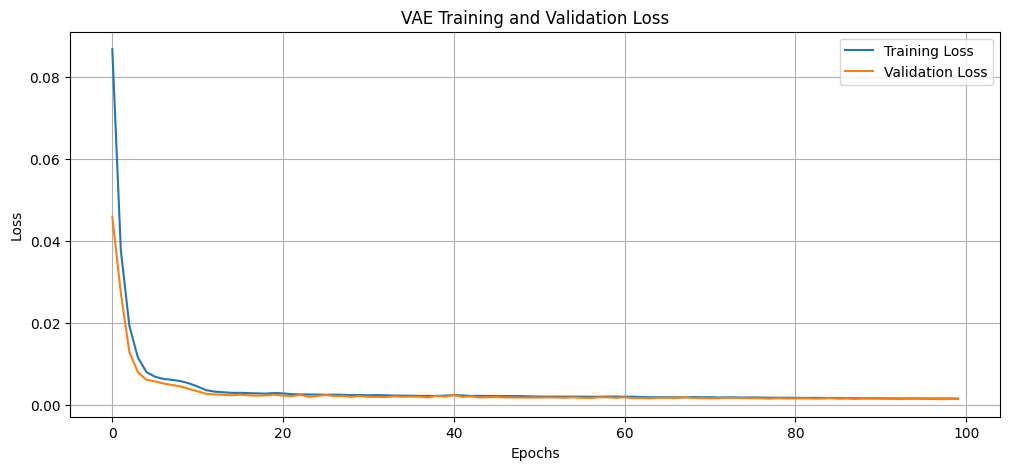

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VAE Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

計算重建誤差+成功率統計

In [7]:
def compute_vae_errors(model, x_data):
  reconstructions = model.predict(x_data, batch_size=32)
  errors = np.mean(np.square(x_data - reconstructions), axis=(1, 2, 3))
  return errors

# base on "good" to setting "threshold"
good_errors = compute_vae_errors(vae, x_test["good"])
threshold = np.mean(good_errors) + 3 * np.std(good_errors)
print(f"Dynamic Threshold: {threshold:.6f}")

#統計各類型準確率
for label, data in x_test.items():
  if len(data) == 0:
    continue
  errors = compute_vae_errors(vae, data)
  if label == "good":
    correct = np.sum(errors < threshold)
  else:
    correct = np.sum(errors > threshold)
  accuracy = correct / len(data)
  print(f"Class:{label.ljust(8)} Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Dynamic Threshold: 0.002460
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class:good     Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class:hole     Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class:print    Accuracy: 88.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Class:cut      Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Class:crack    Accuracy: 50.00%


畫出異常檢視結果

Visualizinghole
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


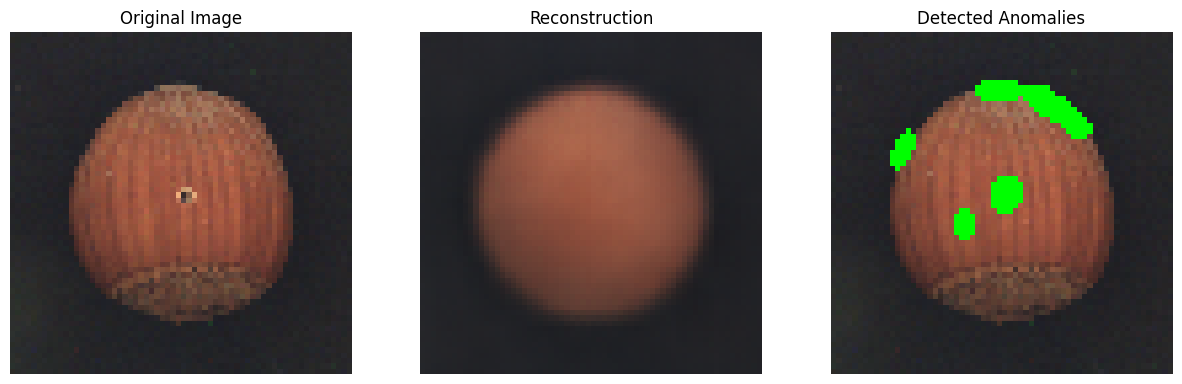

Visualizingprint
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


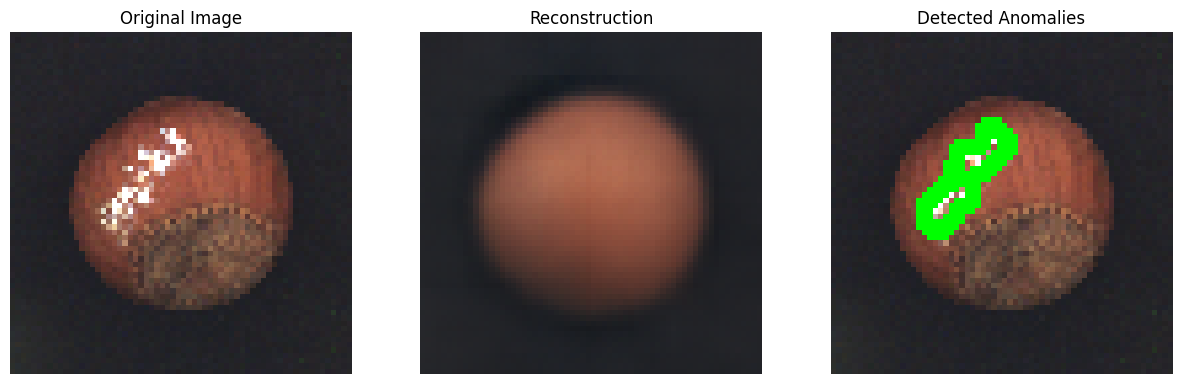

Visualizingcut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


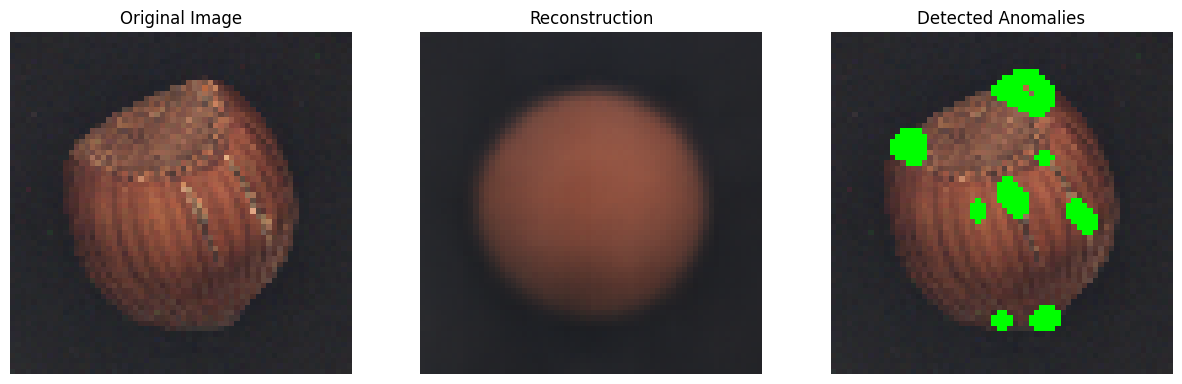

Visualizingcrack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


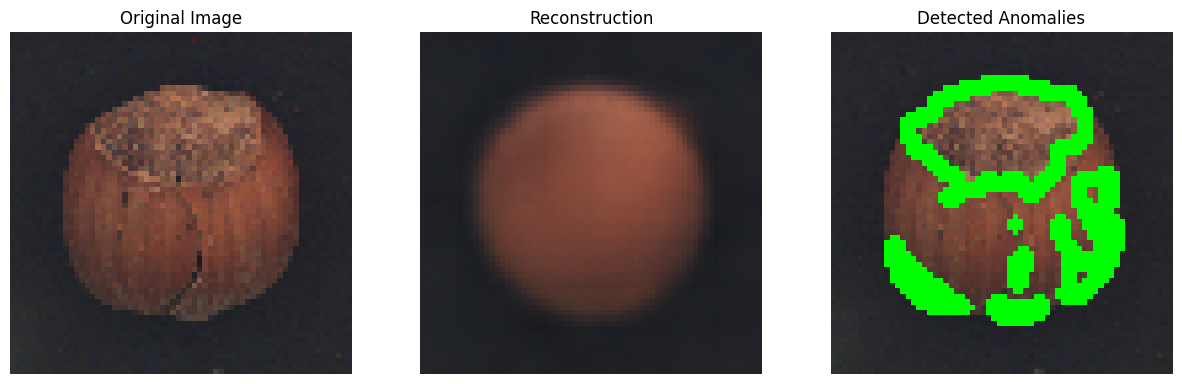

In [8]:
import cv2

def show_reconstrucion(model, x_sample, threshold_val=0.2):
  reconstructions = model.predict(x_sample[None, ...])[0]
  residual = np.abs(x_sample - reconstructions)
  residual_sum = np.sum(residual, axis=2)
  residual_norm = (residual_sum - residual_sum.min()) / (residual_sum.max() - residual_sum.min())
  residual_map = (residual_norm * 255).astype(np.uint8)
  blurred = cv2.GaussianBlur(residual_map, (5, 5), 0)
  _, binary = cv2.threshold(blurred, int(threshold_val * 255), 255,  cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  orig_img = (x_sample * 255).astype(np.uint8).copy()
  cv2.drawContours(orig_img, contours, -1, (0, 255, 0), 2)

  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(x_sample)
  axs[0].set_title("Original Image")
  axs[1].imshow(reconstructions)
  axs[1].set_title("Reconstruction")
  axs[2].imshow(orig_img)
  axs[2].set_title("Detected Anomalies")
  for ax in axs: ax.axis('off')
  plt.show()

#隨機抽樣異常
import random
for label in ["hole", "print", "cut", "crack"]:
  if len(x_test[label]) > 0:
    print(f"Visualizing{label}")
    show_reconstrucion(vae, random.choice(x_test[label]))

pyTorch Autoencoder +異常偵測

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np # Import numpy for astype, but it's not needed after fixing

class ImageDataset(Dataset):
  def __init__(self, image_paths, transform):
    self.image_paths = image_paths
    self.transform = transforms.ToTensor()

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    imag_path = self.image_paths[idx]
    img = Image.open(imag_path).convert("RGB")
    img = self.transform(img)
    return img


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np # Import numpy for astype, but it's not needed after fixing


class UNAutoencoder(nn.Module):
  def __init__(self):
    super(UNAutoencoder, self).__init__()

    self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(2, 2)

    self.bottleneck = nn.Conv2d(256, 512, kernel_size=3, padding=1)

    self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.dec_conv3 = self.conv_block(512, 256)
    self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.dec_conv2 = self.conv_block(256, 128)
    self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.dec_conv1 = self.conv_block(128, 64)

    self.out_conv = nn.Conv2d(64, 3, kernel_size=1)
    self.sigmoid = nn.Sigmoid()

  def conv_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    e1 = self.enc_conv1(x)
    p1 = self.pool1(e1)
    e2 = self.enc_conv2(p1)
    p2 = self.pool2(e2)
    e3 = self.enc_conv3(p2)
    p3 = self.pool3(e3)

    b = self.bottleneck(p3)

    d3 = self.upconv3(b)

    d3 = torch.cat([d3, e3], dim=1)
    d3 = self.dec_conv3(d3)

    d2 = self.upconv2(d3)
    d2 = torch.cat([d2, e2], dim=1)
    d2 = self.dec_conv2(d2)

    d1 = self.upconv1(d2)
    d1 = torch.cat([d1, e1], dim=1)
    d1 = self.dec_conv1(d1)

    out = self.out_conv(d1)
    out = self.sigmoid(out)

    return out



In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np # Import numpy for astype, but it's not needed after fixing

class UNetAutoencoder_Lite(nn.Module):
    def __init__(self):
        super(UNetAutoencoder_Lite, self).__init__()
        # 將通道數減半：64->32, 128->64, etc.
        self.enc_conv1 = self.conv_block(3, 32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc_conv2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc_conv3 = self.conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bottleneck_conv = self.conv_block(128, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv3 = self.conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = self.conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv1 = self.conv_block(64, 32)
        self.out_conv = nn.Conv2d(32, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    # conv_block 和 forward 函式與原版相同，此處省略...
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

    def forward(self, x):
      e1 = self.enc_conv1(x)
      p1 = self.pool1(e1)
      e2 = self.enc_conv2(p1)
      p2 = self.pool2(e2)
      e3 = self.enc_conv3(p2)
      p3 = self.pool3(e3)

      b = self.bottleneck(p3)

      d3 = self.upconv3(b)

      d3 = torch.cat([d3, e3], dim=1)
      d3 = self.dec_conv3(d3)

      d2 = self.upconv2(d3)
      d2 = torch.cat([d2, e2], dim=1)
      d2 = self.dec_conv2(d2)

      d1 = self.upconv1(d2)
      d1 = torch.cat([d1, e1], dim=1)
      d1 = self.dec_conv1(d1)

      out = self.out_conv(d1)
      out = self.sigmoid(out)

      return out

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model_path = 'unet_autoencoder_hazelnut.pth'
model = UNAutoencoder().to(device)

transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

try:
  train_dir = train_dir = os.path.join(base_dir, "train/good")
  if not os.path.exists(train_dir): raise FileNotFoundError
except(NameError, FileNotFoundError):
    train_dir = "./Hw03Rawdata/hazelnut/train/good"


train_images = glob.glob(os.path.join(train_dir, "*.png"))
print(f"--- 偵錯資訊 ---")
print(f"正在此路徑中尋找圖片: '{train_dir}'")
print(f"找到 {len(train_images)} 張 .png 格式的訓練圖片。")
print(f"--------------------")

#if not os.path.exists(new_model_path) and train_images:
#  print(f"找不到U-Net模型檔案: {new_model_path}, 開始訓練...")

train_dataset = ImageDataset(train_images, transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

for epoch in range(n_epochs):
  model.train()
  running_loss = 0.0
  for imgs in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}"):
    imgs = imgs.to(device)
    outputs = model(imgs)
    loss = criterion(outputs, imgs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * imgs.size(0)

  epoch_loss = running_loss / len(train_loader.dataset)
  print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")

torch.save(model.state_dict(), new_model_path)
print(f"U-Net 模型訓練完成，模型已儲存至‘’{new_model_path}")

#else:
#  print(f"找到或已存在U-Net模型檔案 ‘’{new_model_path}, 跳過訓練")

NameError: name 'UNAutoencoder' is not defined

In [18]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, 4, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU()
    )
    # Added the decoder part
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1), nn.Sigmoid() # Output layer
    )


  def forward(self, x):
    return self.decoder(self.encoder(x))


# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'autoencoder_hazelnut.pth'
model = Autoencoder().to(device)

transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

try:
  train_dir = os.path.join(base_dir, "train/good")
  if not os.path.exists(train_dir): raise FileNotFoundError

except(NameError, FileNotFoundError):
    train_dir = "./Hw03Rawdata/hazelnut/train/good"

train_images = glob.glob(os.path.join(train_dir, "*.png"))

if not os.path.exists(model_path) and train_images:
  print(f"找不到模型檔案: {model_path}, 開始訓練...")
  train_dataset = ImageDataset(train_images, transform_pipeline)
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) # Reduced batch size further

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  n_epochs = 20

  for epoch in range(n_epochs):
    running_loss = 0.0
    for imgs in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}"):
      imgs = imgs.to(device)
      outputs = model(imgs)
      loss = criterion(outputs, imgs)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.6f}")

  torch.save(model.state_dict(), model_path)
  print(f"訓練完成,模型儲存至 {model_path}")
else:
  print(f"找到或以純在模型檔案 {model_path},跳過訓練")

找不到模型檔案: autoencoder_hazelnut.pth, 開始訓練...


Epoch 1/20: 100%|██████████| 49/49 [01:00<00:00,  1.24s/it]


Epoch [1/20], Loss: 0.022202


Epoch 2/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [2/20], Loss: 0.003164


Epoch 3/20: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it]


Epoch [3/20], Loss: 0.000551


Epoch 4/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [4/20], Loss: 0.000308


Epoch 5/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [5/20], Loss: 0.000283


Epoch 6/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [6/20], Loss: 0.000231


Epoch 7/20: 100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


Epoch [7/20], Loss: 0.000234


Epoch 8/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [8/20], Loss: 0.000211


Epoch 9/20: 100%|██████████| 49/49 [01:03<00:00,  1.31s/it]


Epoch [9/20], Loss: 0.000231


Epoch 10/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [10/20], Loss: 0.000191


Epoch 11/20: 100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


Epoch [11/20], Loss: 0.000207


Epoch 12/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [12/20], Loss: 0.000176


Epoch 13/20: 100%|██████████| 49/49 [00:59<00:00,  1.20s/it]


Epoch [13/20], Loss: 0.000193


Epoch 14/20: 100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


Epoch [14/20], Loss: 0.000173


Epoch 15/20: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it]


Epoch [15/20], Loss: 0.000213


Epoch 16/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [16/20], Loss: 0.000164


Epoch 17/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [17/20], Loss: 0.000167


Epoch 18/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [18/20], Loss: 0.000180


Epoch 19/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


Epoch [19/20], Loss: 0.000154


Epoch 20/20: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]

Epoch [20/20], Loss: 0.000162
訓練完成,模型儲存至 autoencoder_hazelnut.pth


Evaluation + Visualize

In [19]:
def compute_ae_errors(model, image_paths, transform):
  model.eval()
  errors = []
  device = next(model.parameters()).device
  with torch.no_grad():
    for path in image_paths:
      img = Image.open(path).convert("RGB")
      tensor = transform(img).unsqueeze(0).to(device)
      output = model(tensor)

      pixel_errors = (tensor - output)**2
      pixel_errors_flat = pixel_errors.view(-1)

      k = int(len(pixel_errors_flat) * 0.01)

      top_k_error = torch.topk(pixel_errors_flat, k).values.mean().item()
      errors.append(top_k_error)
  return np.array(errors)



In [20]:
# 載入已訓練的模型權重
#model.load_state_dict(torch.load("unet_autoencoder_hazelnut.pth", map_location=device))
model.load_state_dict(torch.load('autoencoder_hazelnut.pth', map_location=device))
print("成功載入模型權重。")

# Define test_all_path here
try:
  test_dir = os.path.join(base_dir, "test")
  if not os.path.exists(test_dir): raise FileNotFoundError
except(NameError, FileNotFoundError):
  test_dir = "./Hw03Rawdata/hazelnut/test"

anomaly_types = ["good", "hole", "print", "cut", "crack"]
test_all_path = {atype: glob.glob(os.path.join(test_dir, atype, "*.png")) for atype in anomaly_types}


# 對「正常」的測試樣本計算一次重建誤差
print("\n正在計算 'good' 樣本的重建誤差...")
good_errors = compute_ae_errors(model, test_all_path['good'], transform_pipeline)

# 根據正常樣本的誤差分佈，計算異常閾值
threshold_ae = good_errors.mean() + 3 * good_errors.std()
print(f"計算出的異常閾值 (AE Threshold): {threshold_ae:.6f}")

# 使用上面計算出的 threshold_ae 來評估所有類別的準確率
print("\n--- 模型評估結果 ---")
for label, paths in test_all_path.items():
    if label == 'good':
        # 直接使用上面已算出的 good_errors 進行評估
        errors = good_errors
    else:
        # 只對異常類別計算誤差
        print(f"正在計算 '{label}' 樣本的重建誤差...")
        errors = compute_ae_errors(model, paths, transform_pipeline)

    # 判斷準確率
    if label == "good":
        # 如果是 'good' 類別，準確率 = 誤差低於閾值的比例
        acc = np.mean(errors < threshold_ae)
    else:
        # 如果是異常類別，準確率 = 誤差高於或等於閾值的比例
        acc = np.mean(errors >= threshold_ae)

    print(f"類別: {label.ljust(8)} | 準確率: {acc:.2%}")

成功載入模型權重。

正在計算 'good' 樣本的重建誤差...
計算出的異常閾值 (AE Threshold): 0.018274

--- 模型評估結果 ---
類別: good     | 準確率: 100.00%
正在計算 'hole' 樣本的重建誤差...
類別: hole     | 準確率: 77.78%
正在計算 'print' 樣本的重建誤差...
類別: print    | 準確率: 100.00%
正在計算 'cut' 樣本的重建誤差...
類別: cut      | 準確率: 11.76%
正在計算 'crack' 樣本的重建誤差...
類別: crack    | 準確率: 66.67%


---正在分析 'good': 032.png---


/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 27298 (\N{CJK UNIFIED IDEOGRAPH-6AA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_

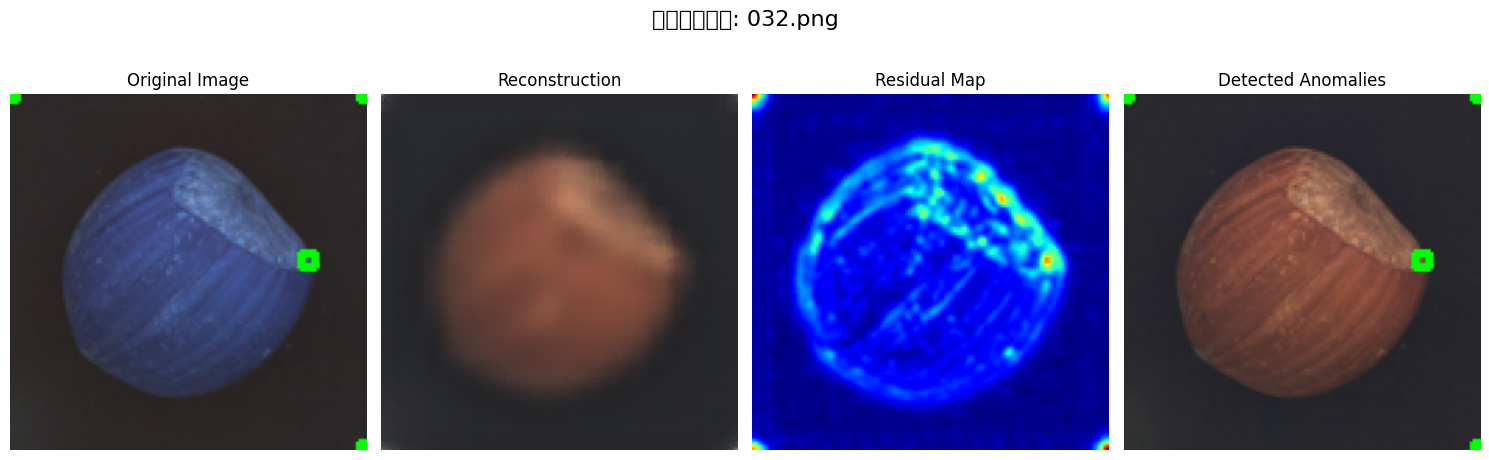

---正在分析 'hole': 012.png---


/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 27298 (\N{CJK UNIFIED IDEOGRAPH-6AA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_

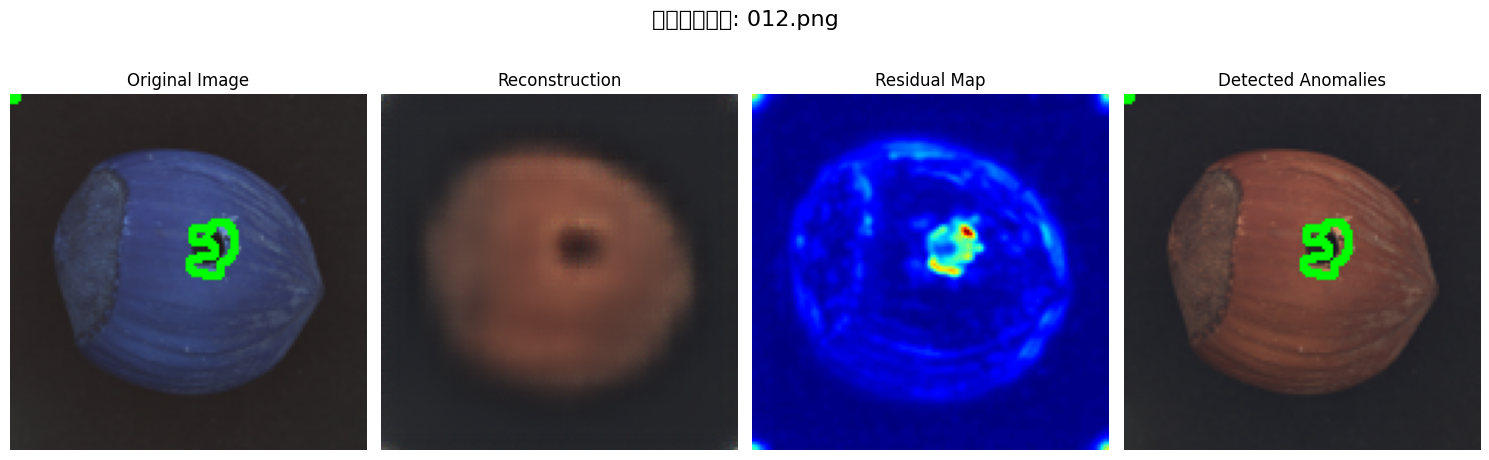

---正在分析 'print': 012.png---


/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 27298 (\N{CJK UNIFIED IDEOGRAPH-6AA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_

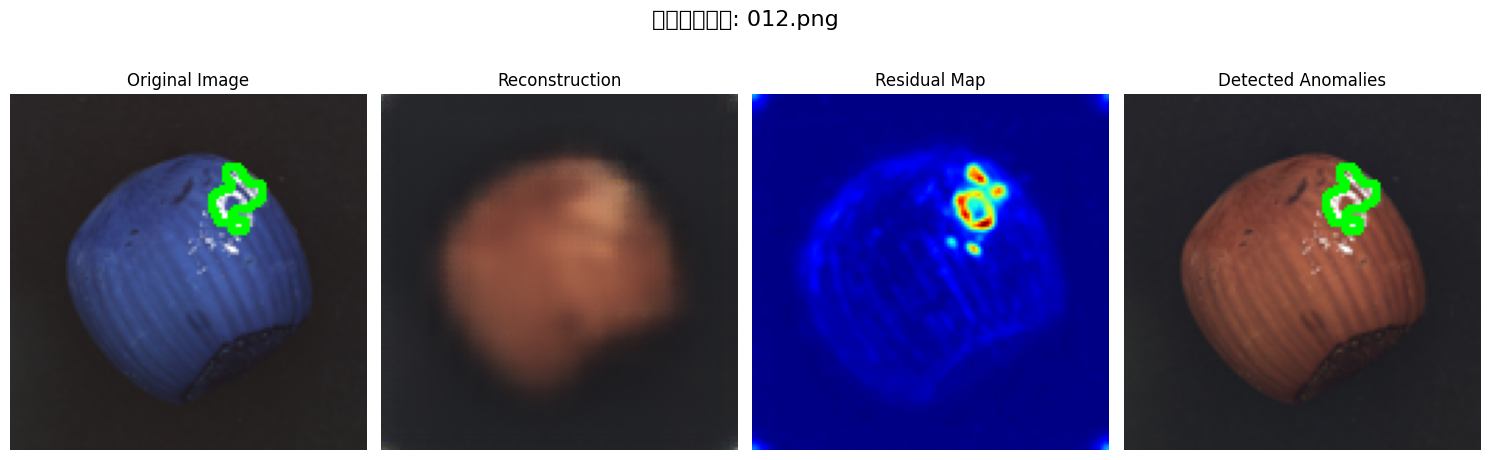

---正在分析 'cut': 015.png---


/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 27298 (\N{CJK UNIFIED IDEOGRAPH-6AA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_

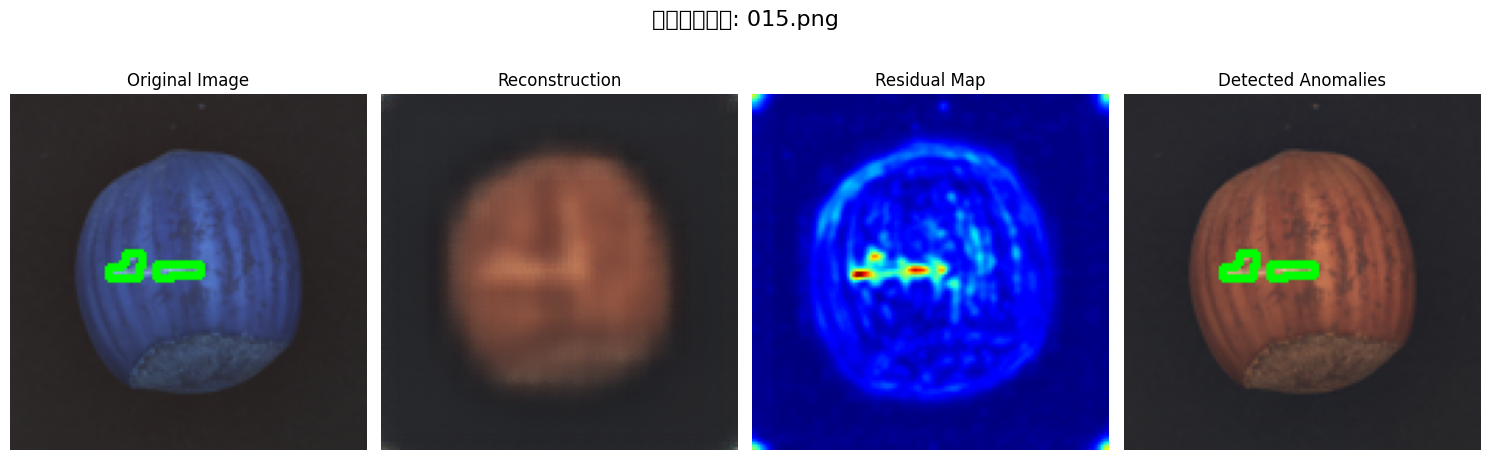

---正在分析 'crack': 017.png---


/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 27298 (\N{CJK UNIFIED IDEOGRAPH-6AA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-749748751.py:78: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_

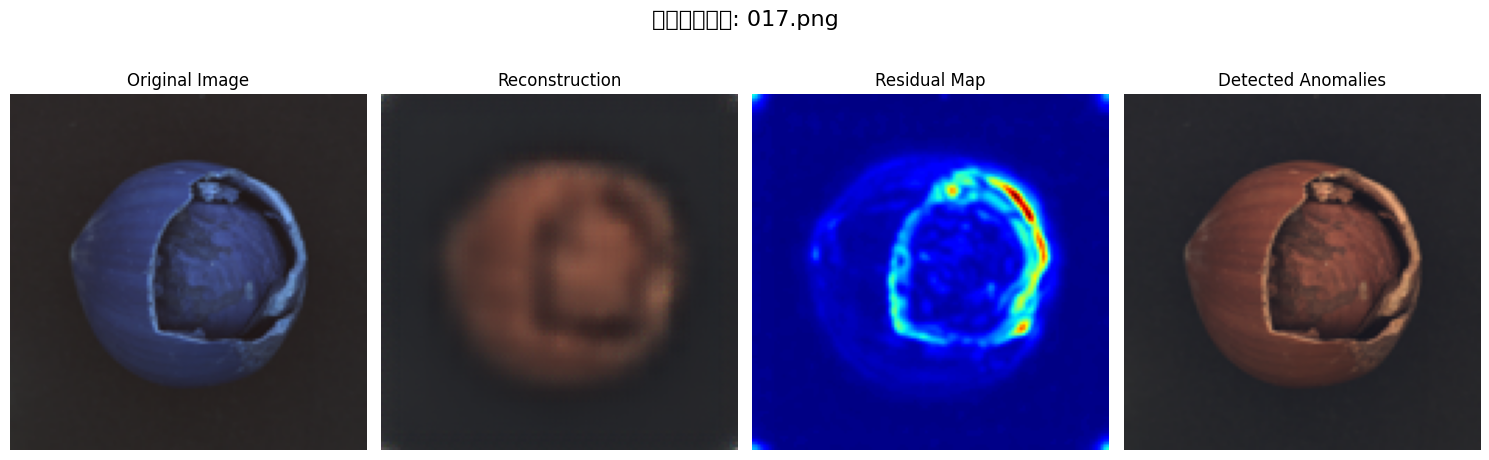

In [27]:
import cv2
from PIL import Image

def show_reconstrucion(model, x_sample, threshold_val=0.1):
  reconstructions = model.predict(x_sample[None, ...])[0]
  residual = np.abs(x_sample - reconstructions)
  residual_sum = np.sum(residual, axis=2)
  residual_norm = (residual_sum - residual_sum.min()) / (residual_sum.max() - residual_sum.min())
  residual_map = (residual_norm * 255).astype(np.uint8)
  blurred = cv2.GaussianBlur(residual_map, (5, 5), 0)
  _, binary = cv2.threshold(blurred, int(threshold_val * 255), 255,  cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  orig_img = (x_sample * 255).astype(np.uint8).copy()
  cv2.drawContours(orig_img, contours, -1, (0, 255, 0), 2)

  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(x_sample)
  axs[0].set_title("Original Image")
  axs[1].imshow(reconstructions)
  axs[1].set_title("Reconstruction")
  axs[2].imshow(orig_img)
  axs[2].set_title("Detected Anomalies")
  for ax in axs: ax.axis('off')
  plt.show()

def visualize_anomalies(model, image_path, transform, device):
  #model.load_state_dict(torch.load(new_model_path, map_location=device))
  model.load_state_dict(torch.load(model_path, map_location=device))
  model.eval()
  #載入並預處理影像
  img = Image.open(image_path).convert("RGB")
  img_tensor = transform(img).unsqueeze(0).to(device)
  #模型重建
  with torch.no_grad():
    reconstruction = model(img_tensor)
  #計算殘差圖
  residual_map = torch.sum(torch.abs(img_tensor - reconstruction), dim=1, keepdim=True)
  residual_map_np = residual_map.squeeze().cpu().numpy()

  #進行高斯模糊以平滑圖像並減少躁點
  residual_map_blur = cv2.GaussianBlur(residual_map_np, (5, 5), 0)

  #殘插圖後處理,正規化0-255, 8-bit整數
  residual_map_norm = (residual_map_np - np.min(residual_map_np)) / (np.max(residual_map_np) - np.min(residual_map_np))
  residual_map_uint8 = (residual_map_norm * 255).astype(np.uint8)
  #進行高斯模糊以平滑圖像並減少躁點
  residual_map_blur = cv2.GaussianBlur(residual_map_uint8, (5, 5), 0)
  #二值化處理
  hight_threshold = np.percentile(residual_map_blur, 98)
  _, binary_mask = cv2.threshold(residual_map_blur, hight_threshold, 255, cv2.THRESH_BINARY)
  binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel=np.ones((5, 5), np.uint8))
  #尋找輪廓
  contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #在原圖上繪製輪廓,將原始tensor轉換為opencv格式
  model_input_size = (128, 128)
  original_pil_resize = img.resize(model_input_size)
  oringinal_cv_img = cv2.cvtColor(np.array(original_pil_resize), cv2.COLOR_RGB2BGR)
  #畫上紅線,線條粗度=2
  cv2.drawContours(oringinal_cv_img, contours, -1, (0, 255, 0), 2)

  original_cv_img_rgb = cv2.cvtColor(oringinal_cv_img, cv2.COLOR_RGB2BGR)
  reconstruction_np = reconstruction.squeeze().cpu().numpy().transpose((1, 2, 0)) # Correct transpose

  #準備顯示圖像
  original_cv_img_rgb = cv2.cvtColor(oringinal_cv_img, cv2.COLOR_BGR2RGB)
  reconstruction_np = reconstruction.squeeze().cpu().numpy().transpose((1, 2, 0)) # Correct transpose

  #結果顯示
  plt.style.use('default')
  fig, axs = plt.subplots(1, 4, figsize=(15, 5))
  fig.suptitle(f"異常檢測結果: {os.path.basename(image_to_test)}", fontsize=16) # Corrected f-string
  axs[0].imshow(oringinal_cv_img); axs[0].set_title("Original Image"); axs[0].axis('off')
  axs[1].imshow(reconstruction_np); axs[1].set_title("Reconstruction"); axs[1].axis('off')
  axs[2].imshow(residual_map_blur, cmap='jet'); axs[2].set_title("Residual Map"); axs[2].axis('off')
  axs[3].imshow(original_cv_img_rgb); axs[3].set_title("Detected Anomalies"); axs[3].axis('off')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

# 1. 載入模型

if os.path.exists(model_path):
  try:
    test_dir = test_dir = os.path.join(base_dir, "test")
    if not os.path.exists(test_dir): raise FileNotFoundError
  except(NameError, FileNotFoundError):
    test_dir = "./Hw03Rawdata/hazelnut/test"

  anomaly_types = ["good", "hole", "print", "cut", "crack"]
  test_all_path = {atype: glob.glob(os.path.join(test_dir, atype, "*.png")) for atype in anomaly_types}
  for label in anomaly_types:
    if test_all_path.get(label):
      image_to_test = random.choice(test_all_path[label])
      print(f"---正在分析 '{label}': {os.path.basename(image_to_test)}---")
      visualize_anomalies(model, image_to_test, transform_pipeline, device)
else:
  print(f"找不到模型'{model_path}, 無法進行視覺化")

Autoencoder vs. VAE

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


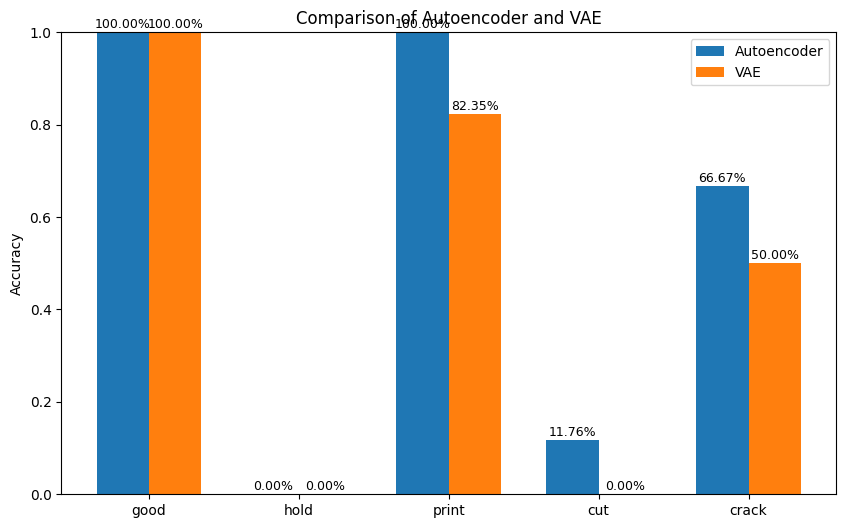

In [28]:
categories = ["good", "hold", "print", "cut", "crack"]

# Create dictionaries to store accuracy results for plotting
acc_ae_dict = {}
acc_vae_dict = {}

# Populate the dictionaries with the calculated accuracies
# Assumes the previous evaluation code has been run and the accuracy values are available
# If the previous code is not run, these values will be based on the last execution output
for label in categories:
  if test_all_path.get(label): # Check if the label exists in test_all_path
    # For Autoencoder
    errors_ae = compute_ae_errors(model, test_all_path[label], transform_pipeline) # Use image paths
    acc_ae = np.mean(errors_ae < threshold_ae) if label == "good" else np.mean(errors_ae >= threshold_ae)
    acc_ae_dict[label] = acc_ae

  if x_test.get(label) is not None and len(x_test[label]) > 0: # Check if the label exists in x_test and is not empty
    # For VAE
    errors_vae = compute_vae_errors(vae, x_test[label])
    acc_vae = np.mean(errors_vae < threshold) if label == "good" else np.mean(errors_vae > threshold)
    acc_vae_dict[label] = acc_vae


ae_acc = [acc_ae_dict.get(cat, 0) for cat in categories]
vae_acc = [acc_vae_dict.get(cat, 0) for cat in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, ae_acc, width, label="Autoencoder")
rects2 = ax.bar(x + width/2, vae_acc, width, label="VAE")

ax.set_ylabel("Accuracy")
ax.set_title("Comparison of Autoencoder and VAE")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 1.0) # Corrected: changed set_ylom to set_ylim
ax.legend()

for rect in rects1 + rects2:
  height = rect.get_height()
  ax.annotate(f"{height:.2%}",
               xy=(rect.get_x() + rect.get_width() / 2, height),
               xytext=(0, 3),
               textcoords="offset points",
               ha="center", fontsize=9)

plt.show()